In [1]:
!pip install torchtext

In [1]:
# Standard library imports
import string
import re
from collections import Counter
from io import open

# Third party imports
import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import pandas as pd
from datasets import load_dataset
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import strip_punctuation, strip_numeric, strip_short, stem_text
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import requests
from spacy.lang.es import Spanish
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer


In [2]:
import nltk
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [4]:
# usamos la GPU si esta disponible
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("Dispositivo usado: GPU con CUDA")
else:
  device = torch.device("mps")
  print("Dispositivo usado: MSP")

Dispositivo usado: MSP


## El dataset utiliado ha sido selecionado de la platafroma hugging-face 

In [5]:
# cargamos el dataset 
dataset = load_dataset("large_spanish_corpus", "DGT")

/Users/ignaciocarrenoromero/anaconda3/envs/Pytorch_DL/lib/python3.10/site-packages/datasets/load.py:1454: FutureWarning: The repository for large_spanish_corpus contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/large_spanish_corpus
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


## Analisis exploratorio del dataset

In [6]:
print(dataset)

# Para ver un ejemplo específico:
print(dataset['train'][5])  
dataset['train'].shape



DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 3168368
    })
})
{'text': 'Visto el Reglamento (CE) no 1234/2007 del Consejo, de 22 de octubre de 2007, por el que se crea una organización común de mercados agrícolas y se establecen disposiciones específicas para determinados productos agrícolas (Reglamento único para las OCM) [1],'}


(3168368, 1)

In [7]:
for i in range(10):
    print(dataset['train'][i]['text'])

Reglamento de Ejecución (UE) no 1073/2012 de la Comisión
de 14 de noviembre de 2012
por el que se establecen valores de importación a tanto alzado para la determinación del precio de entrada de determinadas frutas y hortalizas
LA COMISIÓN EUROPEA,
Visto el Tratado de Funcionamiento de la Unión Europea,
Visto el Reglamento (CE) no 1234/2007 del Consejo, de 22 de octubre de 2007, por el que se crea una organización común de mercados agrícolas y se establecen disposiciones específicas para determinados productos agrícolas (Reglamento único para las OCM) [1],
Visto el Reglamento de Ejecución (UE) no 543/2011 de la Comisión, de 7 de junio de 2011, por el que se establecen disposiciones de aplicación del Reglamento (CE) no 1234/2007 del Consejo en los sectores de las frutas y hortalizas y de las frutas y hortalizas transformadas [2], y, en particular, su artículo 136, apartado 1,
Considerando lo siguiente:
El Reglamento de Ejecución (UE) no 543/2011 establece, en aplicación de los resultados

Para la realización de la actividad 3, se ha utilizado una red LSTM con el fin de combatir los efectos limitantes de las RNN tradicionales, dotando a estas de un sistema de gestión de memoria avanzado. En lugar de seguir el enfoque habitual visto en clase, donde se generan secuencias carácter por carácter mediante las clásicas CharRNN, en este caso se ha optado por una metodología diferente.

Se han entrenado embeddings con un corpus de texto extenso, de 5GB en español, utilizando la herramienta Word2Vec. Posteriormente, se ha utilizado estos embeddings entrenados para pasarle la matriz de pesos correspondiente a la red LSTM. Permitiendo asi capturar mejor la semántica del lenguaje al asociar los índices de las palabras con los correspondientes embeddings.

Una vez entrenados los embeddings, se han visualizado gracias a la herramienta disponible en [TensorFlow Projector](https://projector.tensorflow.org), exportando los archivos en formato TSV. Mediante un análisis de componentes principales (PCA), se ha podido reducir las dimensiones originales de 300 a 3 dimensiones, permitiendo así visualizarlos  para comprobar la efectividad de los embeddings.


In [8]:
# Preprocesamiento de los textos
nltk.download('punkt')
# Función de preprocesamiento 
def preprocess_texts(text):
    filters = [strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric]
    text = preprocess_string(text, filters)
    return text

# Aplicación del preprocesamiento al dataset
processed_texts = [preprocess_texts(text['text']) for text in dataset['train']]

# Entrenamiento del modelo Word2Vec
vector_size = 300  # Tamaño del vector de embedding
window = 5        # Máxima distancia entre la palabra actual y la predicha dentro de una oración

# Entrenamiento del modelo
model = Word2Vec(sentences=processed_texts, vector_size=vector_size, window=window, workers=4)
model.save("word2vec_spanish.model")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ignaciocarrenoromero/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
# Vocavulario del corpues de texto a traves del modelo
word2vec_model = Word2Vec.load("word2vec_spanish.model")  # Carga del modelo Word2Vec
vocab = len(word2vec_model.wv)
print(vocab)

107888


In [10]:
# preparamos los datos para la RNN
# 1. Preparar los Datos para la RNN
class TextDataset(Dataset):
    def __init__(self, texts, word2vec_model, sequence_length=50):
        self.word2vec_model = word2vec_model
        self.sequence_length = sequence_length
        self.vocab_size = len(word2vec_model.wv)
        self.idx_to_word = {i: word for i, word in enumerate(word2vec_model.wv.index_to_key)}
        self.word_to_idx = {word: i for i, word in enumerate(word2vec_model.wv.index_to_key)}
        
        self.samples = []
        for text in texts:
            indices = [self.word_to_idx[word] for word in text if word in self.word_to_idx]
            for i in range(len(indices) - sequence_length):
                self.samples.append(indices[i:i + sequence_length + 1])
                
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        input_sequence = sample[:-1]  # Todas menos la última
        target_sequence = sample[1:]  # Todas menos la primera
        return torch.tensor(input_sequence, dtype=torch.long), torch.tensor(target_sequence, dtype=torch.long)


In [11]:
# creamos el dataset y el dataloader aplicando el modelo word2vec
dataset = TextDataset(processed_texts, word2vec_model, sequence_length=50)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)
dataset.vocab_size

107888

In [13]:
# Almacenamos los embeddings  en un dataframe y lo exportamos en formato tsv 
word_and_vector =  word2vec_model.wv
vectors = word2vec_model.wv.vectors
words = word2vec_model.wv.index_to_key

In [21]:
# almacenamos los datos en un dataframe
df_tsv = pd.DataFrame(vectors)
df_tsv.to_csv('vectors_actividad_3.tsv', sep='\t', index=False, header=False)

In [22]:
# almacenamos los datos en un dataframe
df_tsv = pd.DataFrame(words)
df_tsv.to_csv('words_actividad_3.tsv', sep='\t', index=False, header=False)

<img src="word2vec_visual.png" width="900" height="500">

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, dropout_rate, weights_matrix):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        # Capa de Embedding inicializada con los pesos del modelo Word2Vec
        # Aquí podrías considerar establecer freeze=True si quieres reducir la memoria al no actualizar los embeddings
        self.embedding = nn.Embedding.from_pretrained(weights_matrix, freeze=True)
        
        # Reducir el número de capas y la dimensión oculta puede ayudar a reducir el uso de memoria
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout_rate)
        
        # Capa de Dropout
        self.dropout = nn.Dropout(dropout_rate)
        
        # Simplificando las capas lineales para reducir la complejidad
        self.fc = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, x, hidden):
        # Convertimos índices de palabras en embeddings
        embeds = self.embedding(x)
        
        # Pasamos los embeddings a través de la LSTM
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        # Aplicamos dropout
        out = self.dropout(lstm_out)
        
        # Redimensionamos la salida
        out = out.reshape(-1, self.hidden_dim)
        
        # Pasamos la salida a través de la capa lineal
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # Inicializa estado oculto
        weight = next(self.parameters()).data
        return (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
    def init_weights(self, m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0)
        elif type(m) == nn.LSTM:
            for name, param in m.named_parameters():
                if 'weight_ih' in name:
                    torch.nn.init.xavier_uniform_(param.data)
                elif 'weight_hh' in name:
                    torch.nn.init.orthogonal_(param.data)
                elif 'bias' in name:
                    param.data.fill_(0)
                    # Aseguramos que los sesgos de las puertas de olvido estén inicializadas adecuadamente
                    n = param.size(0)
                    start, end = n // 4, n // 2
                    param.data[start:end].fill_(1.0)


# Parámetros del modelo
vocab_size = len(word2vec_model.wv)  # Tamaño del vocabulario
embedding_dim = 300  # Coincide con la dimensión del modelo Word2Vec 
hidden_dim = 1024  # Dimensión oculta  
n_layers = 4  
dropout_rate = 0.5

# Preparación de los pesos del embedding para la capa de embedding
weights_matrix = torch.FloatTensor(word2vec_model.wv.vectors)

# Creación del modelo
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, n_layers, dropout_rate, weights_matrix)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)


# Generación de grafico computacional de la red LSTM

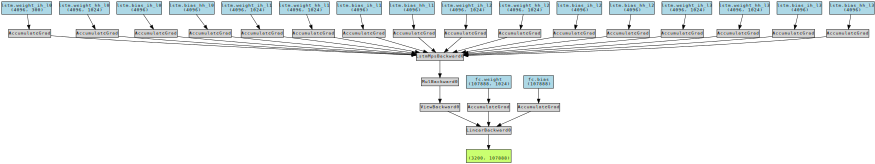

In [15]:
# graficamos el modelo pasandolo a la GPU 'mps'
from torchviz import make_dot
model.to(device)
x = torch.zeros(64, 50, dtype=torch.long).to(device)
hidden = (torch.zeros(n_layers, 64, hidden_dim).to(device),
          torch.zeros(n_layers, 64, hidden_dim).to(device))
dot = make_dot(model(x, hidden)[0], params=dict(model.named_parameters()))

dot

In [16]:
device = torch.device('mps')  # Dispositivo de cómputo para los Apple Silicon ARM
model = model.to(device)

# Función de entrenamiento

In [17]:
def train_model(model, data_loader, loss_function, optimizer, device, num_epochs=10):
    model.train()  # Poner el modelo en modo de entrenamiento

    for epoch in range(num_epochs):
        total_loss = 0

        for inputs, targets in data_loader:
            # Mover los datos al dispositivo adecuado
            inputs, targets = inputs.to(device), targets.to(device)

            # Inicializar el estado oculto para cada batch (considerando el tamaño del batch actual)
            batch_size = inputs.size(0)
            hidden = model.init_hidden(batch_size)
            hidden = tuple([each.data.to(device) for each in hidden])  # Mover el estado oculto al dispositivo

            # Resetear los gradientes acumulados
            model.zero_grad()

            # Pasar los datos a través del modelo
            outputs, hidden = model(inputs, hidden)

            # Calcular la pérdida y realizar backpropagation
            loss = loss_function(outputs, targets.view(-1))  # Redimensionar los targets para que coincidan con la salida
            loss.backward()

            # 'Clip' los gradientes para evitar el problema de la explosión del gradiente
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)

            # Actualizar los pesos del modelo
            optimizer.step()

            # Sumar la pérdida total de la época
            total_loss += loss.item()

            # Imprimir la pérdida promedio de la época
        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {total_loss / len(data_loader)}')





In [18]:
# funcion de evaluacion del modelo
def evaluate_model(model, data_loader, loss_function, device):
    model.eval()  # Pone el modelo en modo de evaluación
    model.to(device)  # Envía el modelo al dispositivo (CPU o GPU)

    total_loss = 0
    total_samples = 0

    with torch.no_grad():  # No se necesitan gradientes para la evaluación
        for texts, labels in data_loader:
            texts, labels = texts.to(device), labels.to(device)

            # Forward pass
            outputs, _ = model(texts, model.init_hidden(texts.size(0)))
            loss = loss_function(outputs, labels.view(-1))

            total_loss += loss.item()
            total_samples += labels.size(0)

    average_loss = total_loss / len(data_loader)
    print(f'Test Loss: {average_loss:.4f}')


In [ ]:
train_model(model, data_loader, loss_function, optimizer, device, num_epochs=4)

In [12]:
# Suponiendo que 'word2vec_model' es tu modelo Word2Vec entrenado
word_to_idx = {word: idx for idx, word in enumerate(word2vec_model.wv.index_to_key)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
word_to_idx['el']


2

In [51]:
def generate_text(seed_text, model, word_to_idx, idx_to_word, sequence_length, num_words, device, temperature=1.0):
    model.eval()  # Poner el modelo en modo evaluación
    words = seed_text.split()
    
    # Generar texto palabra por palabra
    for _ in range(num_words):
        # Preprocesar el texto de semilla actual
        tokenized_text = [word_to_idx.get(word, word_to_idx.get('<UNK>', 0)) for word in words[-sequence_length:]]
        input_sequence = torch.tensor(tokenized_text, dtype=torch.long).unsqueeze(0).to(device)
        
        # Obtener la predicción del modelo
        with torch.no_grad():
            hidden = model.init_hidden(1)
            hidden = tuple([each.data.to(device) for each in hidden])
            output, _ = model(input_sequence, hidden)
        
        # Ajustar la temperatura
        output = output / temperature
        probabilities = torch.nn.functional.softmax(output[-1], dim=0).cpu().numpy()
        
        # Elegir la próxima palabra basada en las probabilidades ajustadas
        word_index = np.random.choice(len(probabilities), p=probabilities)
        word = idx_to_word.get(word_index, '<UNK>')  # Asegúrate de manejar palabras desconocidas
        
        words.append(word)
    
    return ' '.join(words)


In [53]:
# Asegúrate de que el modelo y los datos están en el mismo dispositivo (CPU o GPU)
device = torch.device('mps')

# Texto inicial (semilla), ajusta esto como desees
seed_text = "este es el comienzo"
num_words_to_generate = 50  # Número de palabras a generar
sequence_length = 50  # Debería ser el mismo que se utilizó durante el entrenamiento

# Generar texto
generated_text = generate_text(seed_text, model, word_to_idx, idx_to_word, sequence_length, num_words_to_generate, device, temperature=0.8)
print(generated_text)



este es el comienzo Campione dicha pieles restituciones punto Países bien Guyana interesadas plano decisión Energía Reglamento emisión EUR República aplicable transformación controlar artículo Estados valor ayuda diciembre Polonia Colombia establecimiento República usuario situación consumo estudiar abril comunes situación seis dos respaldar apartado ayuda servicios unidades respecto capital anexo productos ejerce determinada índices Estados


In [ ]:
import torch
import torch.onnx

# Asegúrate de que el modelo esté en modo de evaluación.
model.to('cpu')  # Mueve el modelo al CPU antes de la exportación
model.eval()  

# Crear un tensor de entrada de ejemplo. Las dimensiones deben coincidir con las que espera tu modelo.
sequence_length = 50  # Ajusta esto a la longitud de secuencia correcta para tu modelo
batch_size = 1  # ONNX exporta funciona con un tamaño de lote fijo, pero luego puedes ejecutar el modelo con cualquier tamaño de lote.
dummy_input = torch.LongTensor(batch_size, sequence_length).zero_()  # Ejemplo de entrada tensor.

# También debes crear un estado oculto inicial.
# El tamaño del estado oculto depende de tu modelo específico (num_layers, batch_size, hidden_dim).
hidden_dim = 256  # Ajusta esto según tu modelo.
num_layers = 4   # Ajusta esto según tu modelo.
hidden = (torch.zeros(num_layers, batch_size, hidden_dim),
          torch.zeros(num_layers, batch_size, hidden_dim))  # Estado oculto y estado de la celda para LSTM

# Define el nombre del archivo ONNX de salida.
onnx_filename = "lstm_model.onnx"
dummy_input = dummy_input.to('cpu')
hidden = (hidden[0].to('cpu'), hidden[1].to('cpu'))

# Exportar el modelo. Aquí, pasamos tanto dummy_input como hidden al modelo durante la exportación.
torch.onnx.export(model,                       # Modelo PyTorch a exportar.
                  (dummy_input, hidden),      # Un ejemplo o dummy input para la traza, incluyendo el estado oculto.
                  onnx_filename,              # Nombre del archivo donde se guardará el modelo.
                  export_params=True,         # Exportar parámetros del modelo (pesos y sesgos).
                  opset_version=11,           # La versión de ONNX a utilizar.
                  do_constant_folding=True,   # Optimizar constantes (plegarlas).
                  input_names=['input', 'hidden'],     # Nombres de los inputs del modelo.
                  output_names=['output'],    # Nombres de los outputs del modelo.
                  dynamic_axes={'input': {0: 'batch_size'},    # Establecer ejes dinámicos.
                                'output': {0: 'batch_size'},
                                'hidden': {1: 'batch_size'}})

print(f"Modelo exportado a {onnx_filename}")
